### MODELO 1

Realizar una red convolucional de 3 capas, con dropout y max pooling utilizando la librería de
PyTorch para clasificar números escritos a mano del dataset MNIST

Calcular la precisión del modelo presentado e intentar que sea > 0.85

##### TODO:

1. Load and normalizing the MNIST training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
# Importando módulos de Pytorch
import torch
import torchvision
import torchvision.transforms as transforms

# -- Pytorch MNIST Dataset
from torchvision.datasets import MNIST

# -- DataLoader
from torch.utils.data import DataLoader

# -- Pytorch Neural network modules
import torch.nn as nn
import torch.nn.functional as F

# -- Pytorch Optim
import torch.optim as optim

# Importando módulos de visualización de datos
import matplotlib.pyplot as plt



1. Load and normalizing the MNIST training and test datasets using torchvision

In [2]:
# Transforming the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

batch_size = 10
root_dir = './data/mnist'

trainset = MNIST(root=root_dir, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = MNIST(root=root_dir, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


2. Define a Convolutional Neural Network (To fullfil the assign, This neural network should be 3-layer neural network)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)        
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear( 320 , 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        
        # input is 28x28x1
        # conv1(kernel=5, filters=10) 28x28x10 -> 24x24x10
        # max_pool(kernel=2) 24x24x10 -> 12x12x10
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        
        # conv2(kernel=5, filters=20) 12x12x20 -> 8x8x20
        # max_pool(kernel=2) 8x8x20 -> 4x4x20
        x = self.conv2(x)
#         x = F.dropout
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(x)
        
        # flatten 4x4x20 = 320
        x = x.view(-1, 320)
        
        # 320 -> 120
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        
        # 120 -> 50
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        # 50 -> 10
        x = self.fc3(x)
        
        # transform to logits
        return F.log_softmax(x)

net = Net()


3. Define a loss function

In [4]:
# Perdida del modelo
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network on the training data

In [5]:
# Los batch_sizes influyen en el loss y el accuracy

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    
    dt_len = len(trainloader)
    i = 0
    
    for data, target in trainloader:
        # get the inputs
        
        inputs, labels = data, target

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % dt_len == 1999: 
            rl = running_loss / dt_len
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, rl, 1 - rl))
            running_loss = 0.0
        
        i += 1
        
print('Finished Training with %d cases' % dt_len )

C:\Users\dev\anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 0.513, accuracy: 0.487
[2,  2000] loss: 0.090, accuracy: 0.910
Finished Training with 6000 cases


5. Test the network on the test data

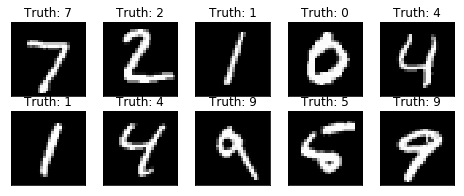

In [6]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(8,3))
for i in range( len(example_data) ):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    title = "Truth: {}".format(example_targets[i])
    ax.set_title(title)
plt.show()


In [7]:
# Predict
outputs = net(example_data)

C:\Users\dev\anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:
_, predicted = torch.max(outputs, 1)

classes = range(0, 10)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:      7     2     1     0     4     1     4     9     5     9


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

C:\Users\dev\anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 95 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

C:\Users\dev\anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 93 %
Accuracy of     3 : 95 %
Accuracy of     4 : 95 %
Accuracy of     5 : 91 %
Accuracy of     6 : 96 %
Accuracy of     7 : 93 %
Accuracy of     8 : 91 %
Accuracy of     9 : 93 %


### MODELO 2

Realizar una red convolucional de 3 capas, con dropout y max pooling utilizando la librería de
Tensorflow para clasificar imágenes del dataset CIFAR10

Calcular la precisión del modelo presentado e intentar que sea > 0.35

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

In [1]:
# Importing basic libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt

# Importing TensorFlow libraries
import tensorflow as tf
import tensorflow.keras.datasets.cifar10 as tf_cifar
import tensorflow.keras.utils as np_utils

In [2]:
(x_train, y_train), (x_test, y_test) = tf_cifar.load_data()

In [3]:
# Informaciones de la Data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_train, img_channels, img_rows, img_cols =  x_train.shape
num_classes = len(np.unique(y_train)) # 10 

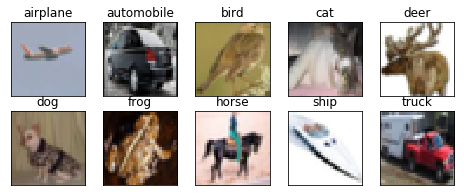

In [4]:
# Print samples
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.reshape(features_idx[img_num,::], [32,32,3])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


## Red Neuronal Convolucional

In [5]:
# Network Configuration Params
batch_size = 128
learning_rate = 0.001
num_steps = 1000
dropout = 0.25

### Tratamiento de la información

In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = y_train.flatten()
y_test = y_test.flatten()


In [7]:
# Creamos la red neuronal de tres capas
def conv_net(x_dict, n_classes, dropout, reuse, is_training):

    with tf.variable_scope('ConvNet', reuse = reuse):
        
        x = tf.reshape(x_dict["images"], shape=[-1, 32, 32, 3])
           
        # Conv1
        conv1 = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[3,3], padding='same')
        conv1 = tf.nn.relu(conv1) 
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv1 = tf.layers.dropout(conv1, rate=0.25)
        
        
        # Conv2
        conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=[3,3])
        conv2 = tf.nn.relu(conv2) 
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv2 = tf.layers.dropout(conv2, rate=0.25)
        
        # Conv3
        conv3 = tf.layers.conv2d(inputs=conv2, filters=64, kernel_size=[3,3], padding='same')
        conv3 = tf.nn.relu(conv2) 
        conv3 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv3 = tf.nn.dropout(conv2, rate=0.25)
  
        flatten = tf.contrib.layers.flatten(conv3)
        fc1 = tf.layers.dense(flatten, 512)
        fc1 = conv2 = tf.nn.relu(fc1) 
        fc1 = tf.layers.dropout(fc1, rate=0.25)
        
        #
        out = tf.layers.dense(fc1, n_classes)
       
        out = tf.nn.softmax(out)
                    
    return out

In [8]:
# Definimos la función del modelo

def model_fn(features, labels, mode):
    
    print(labels)
    print(features)
    
    # Siempre calcular las preds del test
    logits = conv_net(features, num_classes, dropout, reuse=False, is_training=True) # train
    logits_ = conv_net(features, num_classes, dropout, reuse=True, is_training=False) # test
    
    print(logits)
    print(logits)
    
    predictions = {
      "classes": tf.argmax(logits_, axis=1),
      "probabilities": tf.nn.softmax(logits_)
    }
        
    if mode == tf.estimator.ModeKeys.PREDICT:        
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits( labels=tf.cast(labels, dtype=tf.int32), logits=logits )
    cost = tf.reduce_mean(cross_entropy)
  
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate
    )

    train_op = optimizer.minimize(
        loss = cost,
        global_step = tf.train.get_global_step()
    )
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, 
            predictions=predictions["classes"])
    }
    
    estim_specs = tf.estimator.EstimatorSpec( 
        mode = mode, 
        loss = cost, 
        train_op=train_op,
        eval_metric_ops = eval_metric_ops
    )
    
    return estim_specs


In [9]:
# Estimator construction
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\NICOLE~1\\AppData\\Local\\Temp\\tmp6metq0sz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000286783486A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:

# Define the input function for training

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_train }, 
    y= y_train,
    batch_size=batch_size, 
    num_epochs=None, 
    shuffle=True
)


In [11]:
# Train the Model
model.train(input_fn, steps=num_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Tensor("random_shuffle_queue_DequeueMany:2", shape=(128,), dtype=uint8, device=/device:CPU:0)
{'images': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(128, 32, 32, 3) dtype=float64>}
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense i

In [12]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test}, y=y_test,
    batch_size=batch_size, shuffle=True)

# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
Tensor("random_shuffle_queue_DequeueUpTo:2", shape=(?,), dtype=int32, device=/device:CPU:0)
{'images': <tf.Tensor 'random_shuffle_queue_DequeueUpTo:1' shape=(?, 32, 32, 3) dtype=float64>}
Tensor("ConvNet/Softmax:0", shape=(?, 10), dtype=float64)
Tensor("ConvNet/Softmax:0", shape=(?, 10), dtype=float64)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-26T00:38:25Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\NICOLE~1\AppData\Local\Temp\tmp6metq0sz\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-26-00:38:37
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.5412, global_step = 1000, loss = 1.9133745
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\NICO

{'accuracy': 0.5412, 'loss': 1.9133745, 'global_step': 1000}

In [13]:
# Predicción de imágenes simples
n_images = 10
x_test10 = x_test[:n_images]
    
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test10}, 
    shuffle=False
)

# Usamos el modelo para predecir los ejemplos
preds = list(model.predict(input_fn))


INFO:tensorflow:Calling model_fn.
None
{'images': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 32, 32, 3) dtype=float64>}
Tensor("ConvNet/Softmax:0", shape=(?, 10), dtype=float64)
Tensor("ConvNet/Softmax:0", shape=(?, 10), dtype=float64)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\NICOLE~1\AppData\Local\Temp\tmp6metq0sz\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
# Las dibujamos
for i in range(n_images):
    pred = preds[i]['probabilities']
    result = np.where(pred == np.amax(pred))[0][0]
    print("Predicted: %s | real: %s" % (class_names[result], class_names[y_test[i]]))


Predicted: cat | real: cat
Predicted: ship | real: ship
Predicted: ship | real: ship
Predicted: airplane | real: airplane
Predicted: deer | real: frog
Predicted: frog | real: frog
Predicted: automobile | real: automobile
Predicted: bird | real: frog
Predicted: cat | real: cat
Predicted: automobile | real: automobile


### MODELO 3

Realizar una red convolucional de 3 capas, con dropout y max pooling utilizando la librería de
KERAS para clasificar imágenes del dataset CIFAR10

Calcular la precisión del modelo presentado e intentar que sea > 0.35

In [1]:
# Importing basic libraries
import matplotlib.pyplot as plt

# Importing Keras libraries
from keras.datasets import cifar10
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = X_train.reshape(-1,32,32,3)
X_test = X_test.reshape(-1,32,32,3)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(32, 32, 3)

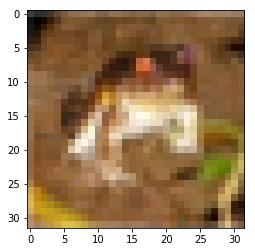

In [3]:
# Visualizing
plt.imshow(X_train[0])

#check image shape
X_train[0].shape

In [4]:
#reshape data to fit model
X_train = X_train.reshape(-1,32,32,3)
X_test = X_test.reshape(-1,32,32,3)

In [5]:
# Define the model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# Compilamos el modelo para calcular su acierto

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Lo entrenamos
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 111s 2ms/step - loss: 1.6243 - acc: 0.3999 - val_loss: 1.2796 - val_acc: 0.5591
Epoch 2/3
50000/50000 [==============================] - 116s 2ms/step - loss: 1.2982 - acc: 0.5365 - val_loss: 1.1004 - val_acc: 0.6149
Epoch 3/3
50000/50000 [==============================] - 118s 2ms/step - loss: 1.1860 - acc: 0.5773 - val_loss: 1.0150 - val_acc: 0.6470


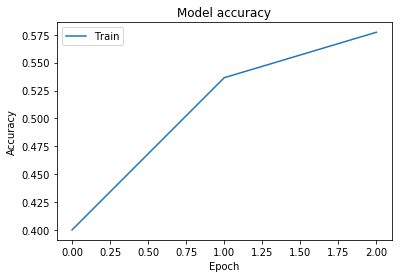

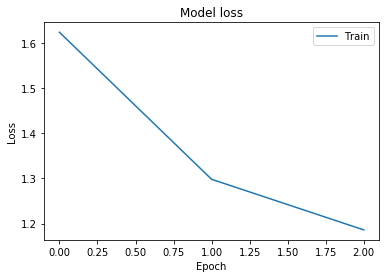

In [8]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [9]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 9s 867us/step


[1.0150049272537232, 0.647]

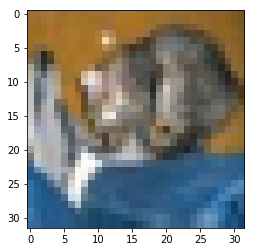

0.45195246 5
Model prediction: dog


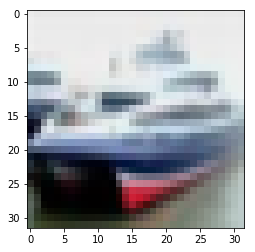

0.86324894 8
Model prediction: ship


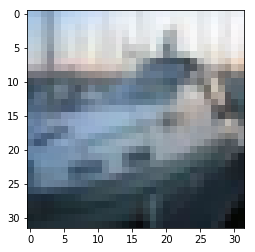

0.6677728 8
Model prediction: ship


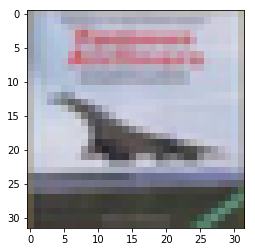

0.52125484 0
Model prediction: airplane


In [10]:
import numpy as np
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

n_image = 4
preds = model.predict(X_test[:n_image])

#Print predictions
for i in range(n_image):
    plt.imshow(X_test[i])
    plt.show()
    max_pred_val = np.amax(preds[i])
    max_pred_val_index = np.where(preds[i] == max_pred_val)[0][0]
    print(max_pred_val, max_pred_val_index)
    pred_class = class_names[max_pred_val_index]
    print("Model prediction:", pred_class)
    
    